In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import boto3
warnings.simplefilter('ignore')

### About data


Aim of the problem is to detect the presence or absence of cardiovascular disease in person based on the given features.
Features available are:


- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Note that:
- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.

Data Source:https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

**Download data**

In [2]:
# Get the service client
s3 = boto3.client('s3')
bucket_name = 'sagemaker-learner'
folder_path = 'data'
data_uri = "s3://sagemaker-learner/data/cardio_train.csv"

try: 
    s3.download_file("sagemaker-learner", "data/cardio.csv", "cardio.csv")
    print(f"File downloaded")
except:
    print(f"Error in file download")

File downloaded


In [3]:
df = pd.read_csv('cardio.csv',sep=";")
df = df.drop(columns=['id'])
print(df.shape)
df.head(3)

(70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [4]:
# feature engineering on age
df['age'] = df['age']/365


**Train - validation - test split**

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['cardio'])
y = df['cardio']

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=42,test_size=0.4)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,stratify=y_test,random_state=42,test_size=0.5)

X_train.shape,X_test.shape,X_val.shape

((42000, 11), (14000, 11), (14000, 11))

In [14]:
df_train = pd.concat([y_train.reset_index(drop=True),X_train.reset_index(drop=True)],axis=1)
df_val = pd.concat([y_val.reset_index(drop=True),X_val.reset_index(drop=True)],axis=1)
df_test = pd.concat([y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)
df_train.shape,df_val.shape,df_test.shape

((42000, 12), (14000, 12), (14000, 12))

## Xgboost model - Training

lets save the data to s3

In [18]:



# since zgboost doesnt support bytes data we will upload csv
df_train.to_csv('train.csv',header = False, index = False)
df_val.to_csv('validation.csv',header = False, index = False)
df_test.to_csv('test.csv',header = False, index = False)



bucket = "sagemaker-learner"
s3_client = boto3.client('s3')


key_path = "cardio_vascular/train.csv"
with open('train.csv','rb') as f:
    response = s3_client.upload_file('train.csv', bucket, key_path)
    print(response)
    

key_path = "cardio_vascular/validation.csv"
with open('validation.csv','rb') as f:
    response = s3_client.upload_file('validation.csv', bucket, key_path)
    print(response)    


key_path = "cardio_vascular/test.csv"
with open('test.csv','rb') as f:
    response = s3_client.upload_file('test.csv', bucket, key_path)
    print(response)

None
None
None


**Define model**

ref: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

We can use xgboost in 2 ways

1. Use xgboost as framework
2. Use xgboost as built in algorithm(here we use this)

In [26]:
# initialize the model
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri

#initialize session
sagemaker_session = sagemaker.Session()
# initialize container
region_name = boto3.Session().region_name
container = get_image_uri(region_name,'xgboost','1.2-2')
# role
role = sagemaker.get_execution_role()

# define output_location 
output_model_location = "s3://sagemaker-learner/cardio_vascular/"


Xgboost_classifier = sagemaker.estimator.Estimator(container,
                                       role,
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=output_model_location,
                                       sagemaker_session=sagemaker_session)



# hyper params
Xgboost_classifier.set_hyperparameters(max_depth=3,
                           objective='multi:softmax',
                           num_class= 2,
                           eta = 0.5,
                           num_round = 50
                           )


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [27]:
from sagemaker.inputs import TrainingInput
# define the data type and paths to the training and validation datasets
content_type = "csv"
train_input = TrainingInput("s3://sagemaker-learner/cardio_vascular/train.csv",content_type=content_type)
validation_input = TrainingInput("s3://sagemaker-learner/cardio_vascular/validation",content_type=content_type)

In [ ]:
# execute the XGBoost training job
Xgboost_classifier.fit({'train': train_input, 'validation': validation_input})

2022-09-06 16:44:35 Starting - Starting the training job...ProfilerReport-1662482675: InProgress
...
2022-09-06 16:45:21 Starting - Preparing the instances for training......
2022-09-06 16:46:32 Downloading - Downloading input data......
2022-09-06 16:47:19 Training - Downloading the training image......
2022-09-06 16:48:28 Training - Training image download completed. Training in progress..[2022-09-06 16:48:33.819 ip-10-0-217-101.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-09-06:16:48:33:INFO] Imported framework sagemaker_xgboost_container.training
[2022-09-06:16:48:33:INFO] Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
[2022-09-06:16:48:33:INFO] No GPUs detected (normal if no gpus installed)
[2022-09-06:16:48:33:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-09-06:16:48:33:INFO] Determined delimiter of CSV input is ','
[2022-09-06:16:48:33:INFO] Determined delimiter of CSV input is ','
[2022-09

## Deploy XGboost as endpoint
facts to consider

1. environment - within sagemaker or outside sagemaker
2. Methods to invok - api call or s3 trigger
3. Data type based on methods - csv or json

In [48]:
from sagemaker.serializers import CSVSerializer

# Deploy the model to perfrom inference 

xgboost_endpoint = Xgboost_classifier.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge',serializer=CSVSerializer())


-------!

In [49]:
xgboost_endpoint.endpoint_name

'sagemaker-xgboost-2022-09-06-17-11-34-041'

In [50]:
df_test = pd.read_csv('test.csv',header=None)
df_test = df_test.drop(columns=[0])
df_test.head()

,1,2,3,4,5,6,7,8,9,10,11
0,47.463014,1,150,62.0,120,80,1,1,0,0,1
1,39.980822,1,161,87.0,160,80,3,3,0,0,0
2,45.709589,2,156,62.0,110,70,1,1,1,1,1
3,49.786301,2,175,79.0,150,110,1,1,1,0,1
4,52.350685,2,175,68.0,140,80,1,1,0,0,1


In [51]:
from sagemaker.serializers import CSVSerializer

test_data_serialized = CSVSerializer().serialize(data=df_test.values)

In [60]:
# test_data = df_test.values
out = xgboost_endpoint.predict(data=test_data_serialized).decode('utf-8')
prediction = [eval(i) for i in out.split("\n")[:-1]]
prediction[0:5]

[0.0, 1.0, 0.0, 1.0, 1.0]

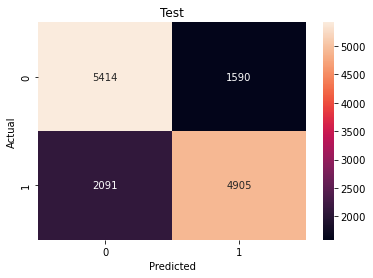

In [62]:
from sklearn.metrics import roc_auc_score,auc,confusion_matrix,roc_curve


y_test_pred = prediction

cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plt.title("Test")
sns.heatmap(cm, annot=True,fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [63]:
xgboost_endpoint.delete_endpoint()